In [48]:
%matplotlib widget

import ipympl
import numpy as np
import open3d as o3d
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import colors

plt.ion()

import sys
sys.path.append('/Users/ehealy/Chicago/Simons_II/photopol')

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial.transform import Rotation as R

import functions as fun
from importlib import reload
import hexa
reload(fun)
reload(hexa)


<module 'hexa' from '/Users/ehealy/Chicago/Simons_II/photopol/hex_analysis/hexa.py'>

# importing point cloud


In [5]:


ply_file = "/Users/ehealy/Chicago/Simons_II/photopol/data/plumbbobv2_maya/point_cloud/Dense_point_cloud 1.ply" # maya's feb 2025 photos

# Define cylinder properties (adjust as needed)
cylinder_center = np.array([-2, -4, 8])  # Center of the cylinder (optional)
cylinder_radius = 5  # Radius from the axis (in whatever units)
cylinder_height = 10   # Height of the cylinder along the z-axis

points, hex_axis, hex_center = hexa.points_to_axis(ply_file, cylinder_center, cylinder_radius, cylinder_height, visualization=False)

In [7]:
print("Cylinder axis direction:", hex_axis)
print("Cylinder center:", hex_center)


Cylinder axis direction: [ 7.70987599e-04 -2.10974471e-03 -9.99997477e-01]
Cylinder center: [-0.74414489 -1.65408988  9.10417972]


In [8]:
transformed_points = hexa.transform_to_new_coord_system(points, hex_axis, hex_center)


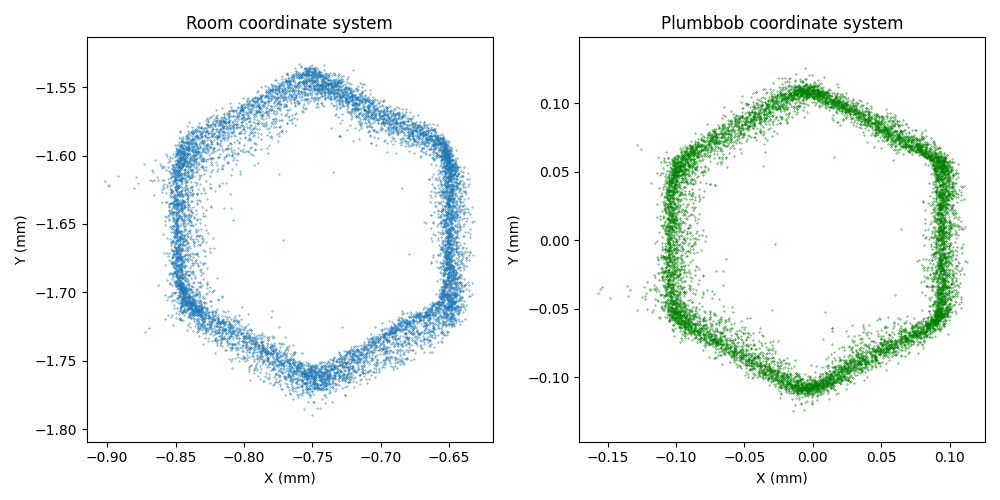

In [12]:
hexa.plot_room_plumbbob_projections(points,transformed_points)

In [14]:
def hexagon_vertices(center, edge_to_edge_radius, angle=0):
    """Calculates the vertices of a regular hexagon given edge-to-edge radius."""
    # Convert edge-to-edge radius to side length
    side_length = edge_to_edge_radius / np.sqrt(3)
    
    x_c, y_c = center
    angles = np.radians(np.arange(0, 360, 60)) + angle
    x = x_c + side_length * np.cos(angles)
    y = y_c + side_length * np.sin(angles)
    return np.stack([x, y], axis=-1)

def point_to_line_distance(point, line_start, line_end):
    """Calculates the distance from a point to a line segment."""
    if np.all(line_start == line_end):
        return np.linalg.norm(point - line_start)
    
    v1 = point - line_start
    v2 = line_end - line_start
    
    # Project v1 onto v2
    projection_length = np.dot(v1, v2) / np.dot(v2, v2)
    
    # If the projection falls outside the line segment, clamp it to the endpoints
    projection_length = max(0, min(1, projection_length))
    
    # Calculate the closest point on the line segment to the point
    closest_point = line_start + projection_length * v2
    
    return np.linalg.norm(point - closest_point)

def objective_function(params, points):
    """Calculates the objective function (sum of squared distances)."""
    center_x, center_y, edge_to_edge_radius, angle = params
    hexagon = hexagon_vertices((center_x, center_y), edge_to_edge_radius, angle)
    
    total_distance = 0
    for point in points:
        min_distance = float('inf')
        for i in range(6):
            distance = point_to_line_distance(point, hexagon[i], hexagon[(i + 1) % 6])
            min_distance = min(min_distance, distance)
        total_distance += min_distance**2
    return total_distance

def fit_hexagon(points, initial_guess=None):
    """Fits a hexagon to a set of points."""
    if initial_guess is None:
        # Calculate the initial guess based on the points
        center_x = np.mean(points[:, 0])
        center_y = np.mean(points[:, 1])
        # Estimate the edge-to-edge radius (we assume a rough initial guess for radius)
        edge_to_edge_radius = np.max(np.linalg.norm(points - [center_x, center_y], axis=1))
        initial_guess = [center_x, center_y, edge_to_edge_radius, np.radians(30)]
    
    result = minimize(objective_function, initial_guess, args=(points,), method='Nelder-Mead')
    
    if result.success:
        center_x, center_y, edge_to_edge_radius, angle = result.x
        return {
            'center': (center_x, center_y),
            'edge_to_edge_radius': edge_to_edge_radius,
            'angle': angle,
            'vertices': hexagon_vertices((center_x, center_y), edge_to_edge_radius, angle)
        }
    else:
        raise RuntimeError("Optimization failed.")

    return hexagon_vertices
    
def hexagon_generation(radius, angle, center, axis):
    vertices = hexagon_vertices(center, radius, angle, axis)
    vertices = np.array(vertices)
    corners = compute_corners(vertices)
    normals = np.empty((6,3))
    for i in range(len(corners)):
        normals[i] = compute_normal_from_corners(corners[i])

    return vertices, corners, normals


def points_to_axis(ply_file, cylinder_center, cylinder_radius, cylinder_height, visualization=True):
    pcd = o3d.io.read_point_cloud(ply_file)
    pcd_cyl = fun.filter_points_in_cylinder(pcd, np.array([0, 0, 1]), cylinder_center, cylinder_radius, 
                                            cylinder_height, visualization=visualization)
    points = np.asarray(pcd_cyl.points)
    hex_axis, hex_center = fun.find_cylinder_axis_and_center_pcd(pcd_cyl, visualization=visualization)

    return points, hex_axis, hex_center

def plot_room_plumbbob_projections(points, transformed_points):
    x = points[:, 0]
    y = points[:, 1]
    
    x2 = transformed_points[:, 0]
    y2 = transformed_points[:, 1]
    
    # Create a figure with two subplots in one row (1 row, 2 columns)
    plt.figure(figsize=(10, 5))  # Set the figure size if needed
    
    # First subplot (top-down view)
    plt.subplot(1, 2, 1)  # (rows, columns, index)
    plt.scatter(x, y, s=0.1)
    plt.axis("equal")
    plt.title("Room coordinate system")
    plt.xlabel("X (mm)")  # Customize as needed
    plt.ylabel("Y (mm)")  # Customize as needed
    
    # Second subplot (fill in with other plot details)
    plt.subplot(1, 2, 2)  # (rows, columns, index)
    plt.scatter(x2, y2, s=0.1, color='green', ) 

    
    plt.axis('equal')
    plt.title("Plumbbob coordinate system")
    plt.xlabel("X (mm)")  
    plt.ylabel("Y (mm)") 
    # plt.legend()
    # Show the plots
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


In [15]:

# Assuming transformed_points is your 3D array
# Extract the x, y coordinates (first two columns)
points_2D = transformed_points[:, :2]

fitted_hexagon = fit_hexagon(points_2D)

print("Fitted Hexagon:")
print("  Center:", fitted_hexagon['center'])
print("  Edge-to-edge Radius:", fitted_hexagon['edge_to_edge_radius'])
print("  Angle:", fitted_hexagon['angle'])
print("  Vertices:\n", fitted_hexagon['vertices'])


Fitted Hexagon:
  Center: (3.3703076129210677e-16, 1.222090480658196e-15)
  Edge-to-edge Radius: 0.19429015612485961
  Angle: 0.514828709824465
  Vertices:
 [[ 0.09763322  0.05523262]
 [ 0.00098376  0.11216916]
 [-0.09664946  0.05693654]
 [-0.09763322 -0.05523262]
 [-0.00098376 -0.11216916]
 [ 0.09664946 -0.05693654]]


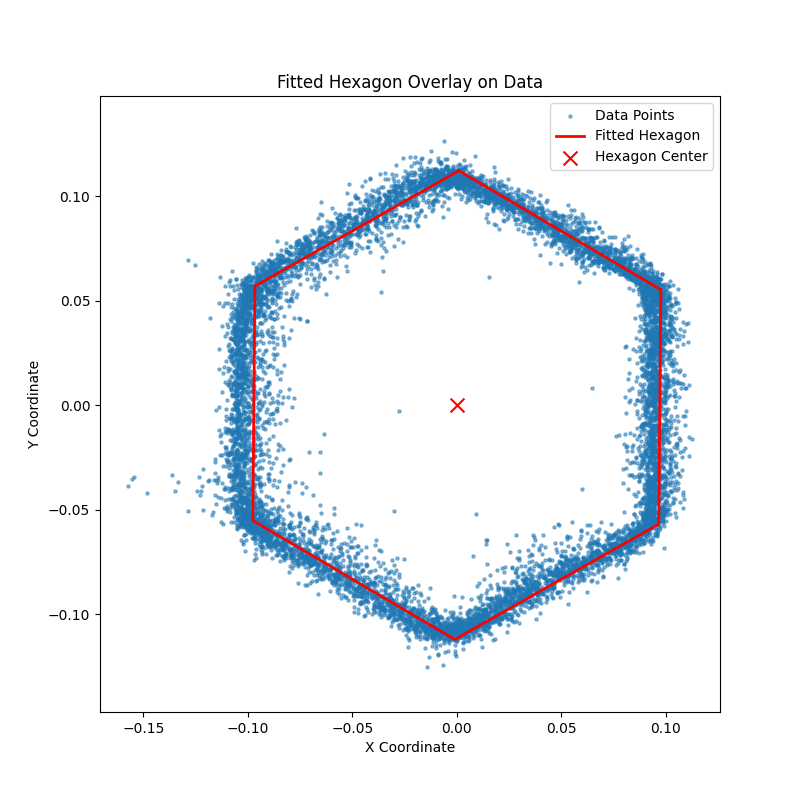

In [16]:
def plot_fitted_hexagon(points, fitted_hexagon):
    """Plots the data points and the fitted hexagon."""
    plt.figure(figsize=(8, 8))
    
    # Scatter plot of points
    plt.scatter(points[:, 0], points[:, 1], s=5, label="Data Points", alpha=0.5)
    
    # Extract hexagon vertices and ensure it's closed
    vertices = fitted_hexagon['vertices']
    vertices = np.vstack([vertices, vertices[0]])  # Close the hexagon
    
    # Plot hexagon
    plt.plot(vertices[:, 0], vertices[:, 1], 'r-', linewidth=2, label="Fitted Hexagon")
    
    # Plot center
    plt.scatter(*fitted_hexagon['center'], color='red', marker='x', label="Hexagon Center", s=100)
    
    # Labels and title
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Fitted Hexagon Overlay on Data")
    plt.legend()
    plt.axis("equal")  # Ensure hexagon is not distorted
    
    plt.show()
# Example Usage

plot_fitted_hexagon(transformed_points, fitted_hexagon)

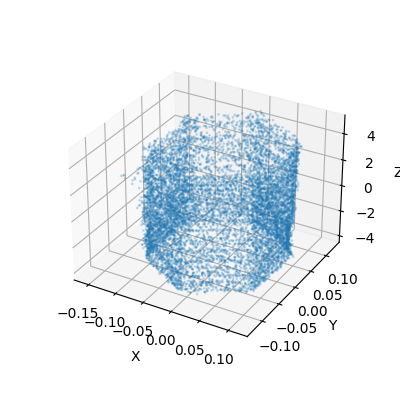

In [17]:
x,y,z = transformed_points[:, 0], transformed_points[:, 1], transformed_points[:, 2]
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, marker='o', label='Data Points', alpha=0.2, s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()


# separating top and bottom halves as statistical check
in development

In [18]:
top_points = points[points[:, 2] > 9]
cylinder_axis_pcd_top = np.load("cylinder_axis_top.npy")
cylinder_center_pcd_top = np.load("cylinder_center_top.npy")

In [19]:
bottom_points = points[points[:, 2] < 9]
cylinder_axis_pcd_bottom = np.load("cylinder_axis_bottom.npy")
cylinder_center_pcd_bottom = np.load("cylinder_center_bottom.npy")

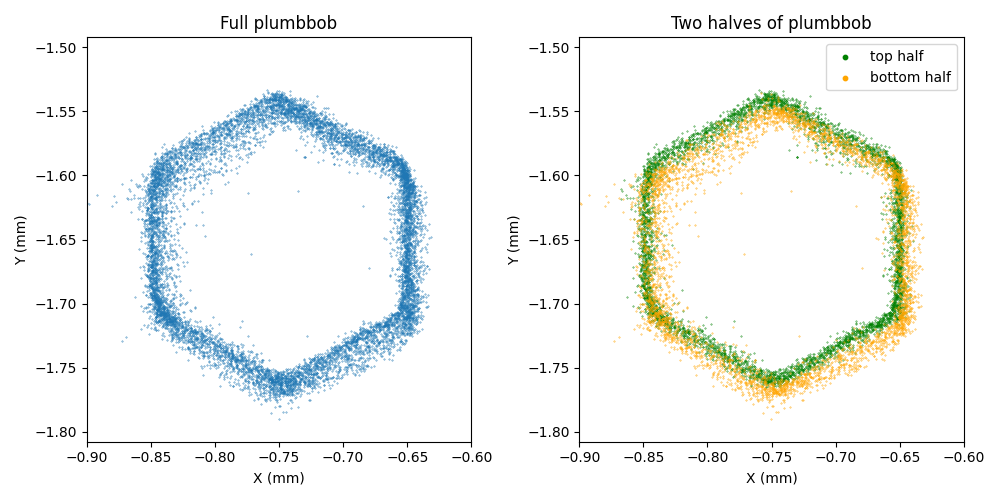

In [20]:
x = points[:, 0]
y = points[:, 1]

x2 = top_points[:, 0]
y2 = top_points[:, 1]

x3 = bottom_points[:, 0]
y3 = bottom_points[:, 1]


# Create a figure with two subplots in one row (1 row, 2 columns)
plt.figure(figsize=(10, 5))  # Set the figure size if needed

# First subplot (top-down view)
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.scatter(x, y, s=0.1)
plt.axis("equal")
plt.xlim(-.9, -.6)  # Set x limits
plt.ylim(-1.8,-1.5)  # Set y limits
plt.title("Full plumbbob")
plt.xlabel("X (mm)")  # Customize as needed
plt.ylabel("Y (mm)")  # Customize as needed

# Second subplot (fill in with other plot details)
plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.scatter(x2, y2, s=0.1, color='green', )  
plt.scatter(x3, y3, s=0.1, color='orange')  
plt.scatter([],[], s=10, color='green', label='top half')
plt.scatter([],[], s=10, color='orange', label='bottom half')

plt.axis('equal')
plt.xlim(-.9, -.6)  # Set x limits
plt.ylim(-1.8,-1.5)  # Set y limits
plt.title("Two halves of plumbbob")
plt.xlabel("X (mm)")  
plt.ylabel("Y (mm)")  
plt.legend()
# Show the plots
plt.tight_layout()  
plt.show()


In [28]:

transformed_points = hexa.transform_to_new_coord_system(points, hex_axis, hex_center)
top_transformed_points = hexa.transform_to_new_coord_system(top_points, cylinder_axis_pcd_top, cylinder_center_pcd_top)
bottom_transformed_points = hexa.transform_to_new_coord_system(bottom_points, cylinder_axis_pcd_bottom, cylinder_center_pcd_bottom)


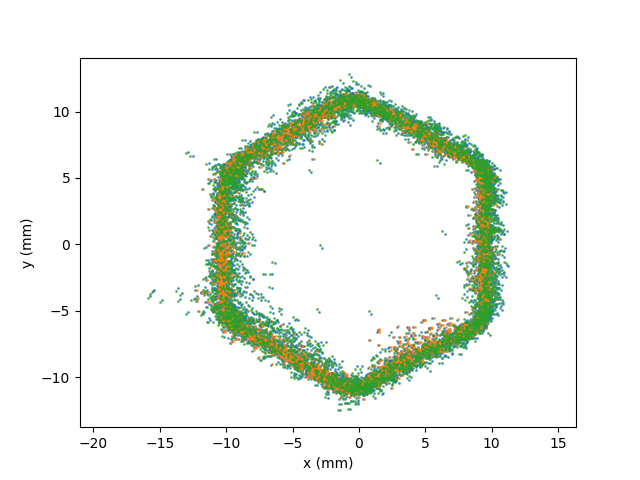

In [30]:

x = transformed_points[:, 0]
y = transformed_points[:, 1]

x2 = top_transformed_points[:, 0]
y2 = top_transformed_points[:, 1]

x3 = bottom_transformed_points[:, 0]
y3 = bottom_transformed_points[:, 1]

plt.figure()
plt.scatter(x*1e2,y*1e2, s=1, alpha=0.7)
plt.scatter(x2*1e2,y2*1e2, s=1, alpha=0.7)
plt.scatter(x3*1e2,y3*1e2, s=1, alpha=0.7)

plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
# plt.scatter(verts_2D[:,0], verts_2D[:,1])

plt.axis("equal")
plt.show()


In [31]:
x_mm = x2*1e2
y_mm = y2*1e2


In [32]:
# check on centered / angle
print(np.mean(x_mm*np.cos(np.pi/6)), np.mean(y_mm*np.sin(np.pi/6)))
print(np.mean(x_mm*np.cos(np.pi/3)), np.mean(y_mm*np.sin(np.pi/3)))
print(np.mean(x_mm), np.mean(y_mm))

-0.033812444744710186 -0.011586722751474742
-0.019521624075317677 -0.02006879249876859
-0.03904324815063518 -0.02317344550294982


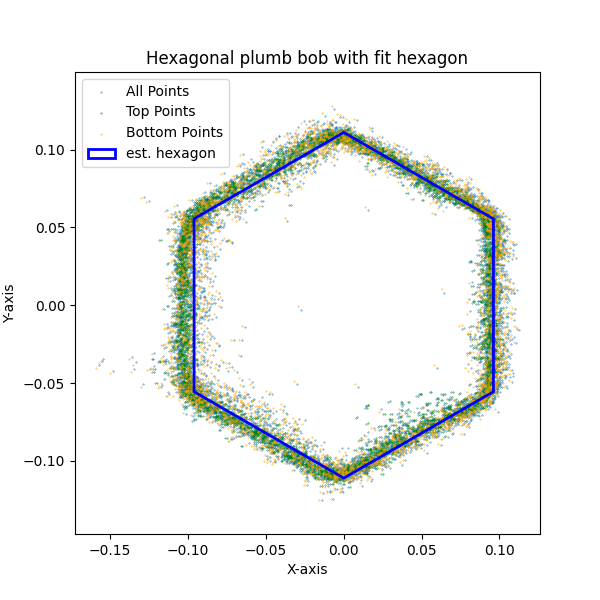

In [33]:
# Hexagon parameters
center = np.array([0,0])  # Center of the hexagon
radius = 0.111  # Radius of the hexagon
angle = np.radians(30)  # Rotation angle (optional)

# Get hexagon vertices
vertices = fun.hexagon_vertices_2D(center, radius, angle)

# Create a plot
plt.figure(figsize=(6,6))
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], s=0.1, label="All Points")
plt.scatter(top_transformed_points[:, 0], top_transformed_points[:, 1], color='green', s=0.1, label="Top Points")
plt.scatter(bottom_transformed_points[:, 0], bottom_transformed_points[:, 1], color='orange', s=0.1, label="Bottom Points")

hexagon = plt.Polygon(vertices, closed=True, edgecolor='blue', fill=None, linewidth=2, label="est. hexagon")
plt.gca().add_patch(hexagon)

plt.axis('equal')

# Add labels and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Hexagonal plumb bob with fit hexagon")
plt.legend()

# Show the plot
plt.show()


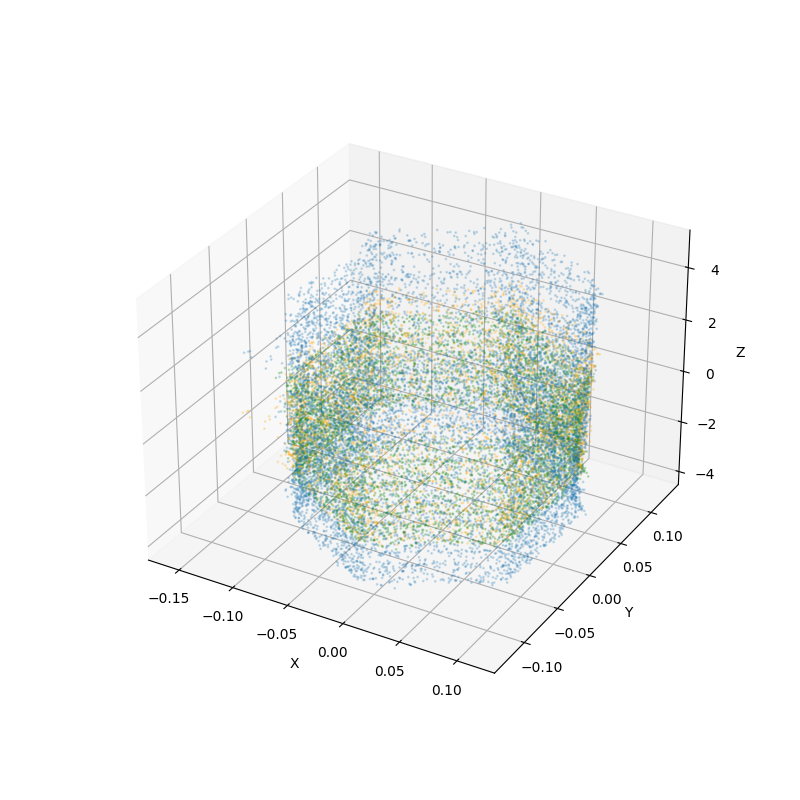

In [34]:

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


# Scatter plot for the data points
ax.scatter(transformed_points[:, 0], transformed_points[:, 1], transformed_points[:, 2], marker='o', label='Data Points', alpha=0.2, s=1)
ax.scatter(top_transformed_points[:, 0], top_transformed_points[:, 1], 
           top_transformed_points[:, 2], color='green', marker='o', label='Data Points', alpha=0.2, s=1)
ax.scatter(bottom_transformed_points[:, 0], bottom_transformed_points[:, 1], 
           bottom_transformed_points[:, 2], color='orange', marker='o', label='Data Points', alpha=0.2, s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# # Set plot limits based on vertices
# ax.set_xlim(np.min(vertices[:, 0]), np.max(vertices[:, 0]))
# ax.set_ylim(np.min(vertices[:, 1]), np.max(vertices[:, 1]))
# ax.set_zlim(np.min(vertices[:, 2]), np.max(vertices[:, 2]))

# Show the plot
plt.show()


# estimating errors

In [35]:
# start here

radius = 0.111  # Radius of the hexagon
angle = np.pi / 6  # Rotation angle (optional)
# Generate 3D hexagon vertices
center = np.zeros(3)
axis = np.array([0,0,1])
vertices = fun.hexagon_vertices(center, radius, angle, axis)

# Print the vertices
print(vertices)
vertices_np = np.array(vertices)

[[ 9.61288198e-02  5.55000000e-02 -5.00000000e+00]
 [ 2.61529032e-17  1.11000000e-01 -5.00000000e+00]
 [-9.61288198e-02  5.55000000e-02 -5.00000000e+00]
 [-9.61288198e-02 -5.55000000e-02 -5.00000000e+00]
 [-6.08473727e-17 -1.11000000e-01 -5.00000000e+00]
 [ 9.61288198e-02 -5.55000000e-02 -5.00000000e+00]
 [ 9.61288198e-02  5.55000000e-02  5.00000000e+00]
 [ 2.61529032e-17  1.11000000e-01  5.00000000e+00]
 [-9.61288198e-02  5.55000000e-02  5.00000000e+00]
 [-9.61288198e-02 -5.55000000e-02  5.00000000e+00]
 [-6.08473727e-17 -1.11000000e-01  5.00000000e+00]
 [ 9.61288198e-02 -5.55000000e-02  5.00000000e+00]]


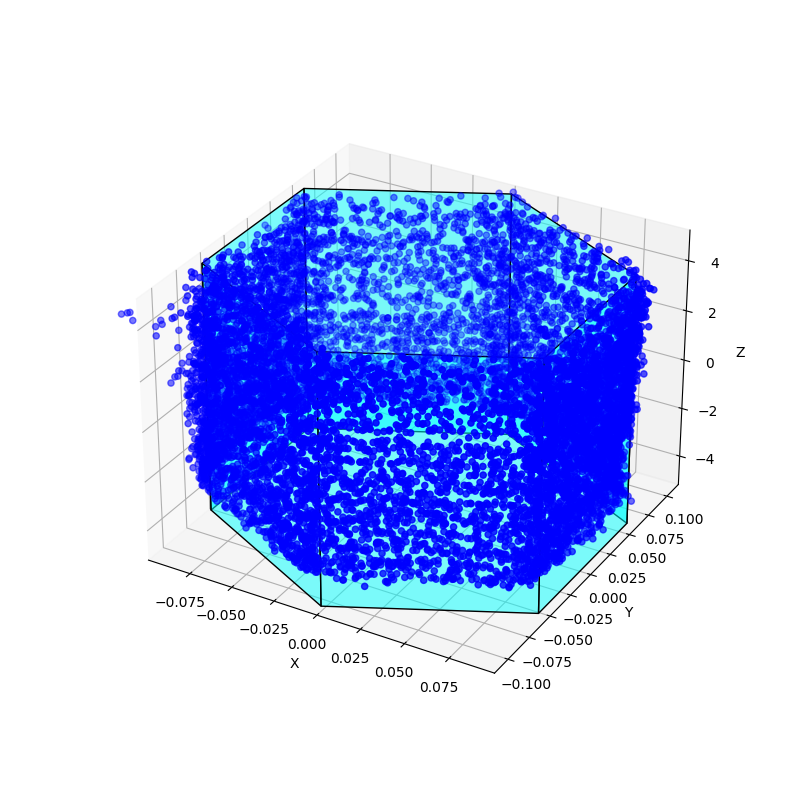

In [36]:
# Define the faces of the hexagonal prism
faces = [
    # [vertices_np[i] for i in [0, 1, 2, 3, 4, 5]],  # Top hexagon
    # [vertices_np[i] for i in [6, 7, 8, 9, 10, 11]],  # Bottom hexagon
    [vertices_np[i] for i in [0, 1, 7, 6]],  # Side faces
    [vertices_np[i] for i in [1, 2, 8, 7]],
    [vertices_np[i] for i in [2, 3, 9, 8]],
    [vertices_np[i] for i in [3, 4, 10, 9]],
    [vertices_np[i] for i in [4, 5, 11, 10]],
    [vertices_np[i] for i in [5, 0, 6, 11]]
]

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the faces
ax.add_collection3d(Poly3DCollection(faces, facecolor='cyan', edgecolor='k', alpha=0.5))
# Scatter plot for the data points
ax.scatter(transformed_points[:, 0], transformed_points[:, 1], 
           transformed_points[:, 2], color='blue', marker='o', label='Data Points')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits based on vertices
ax.set_xlim(np.min(vertices[:, 0]), np.max(vertices[:, 0]))
ax.set_ylim(np.min(vertices[:, 1]), np.max(vertices[:, 1]))
ax.set_zlim(np.min(vertices[:, 2]), np.max(vertices[:, 2]))

# Show the plot
plt.show()

In [37]:
radius = 0.111  # Radius of the hexagon
angle = np.pi / 6  # Rotation angle (optional)
# Generate 3D hexagon vertices
center = np.zeros(3)
axis = np.array([0,0,1])
vertices = fun.hexagon_vertices(center, radius, angle, axis)

# Print the vertices
print(vertices)
vertices_np = np.array(vertices)

corners = hexa.compute_corners(vertices)

normals = np.empty((6,3))
for i in range(len(corners)):
    normals[i] = hexa.compute_normal_from_corners(corners[i])
print(normals)

min_dists = hexa.compute_min_distances(transformed_points, normals, vertices)
top_min_dists = hexa.compute_min_distances(top_transformed_points, normals, vertices)
bottom_min_dists = hexa.compute_min_distances(bottom_transformed_points, normals, vertices)





[[ 9.61288198e-02  5.55000000e-02 -5.00000000e+00]
 [ 2.61529032e-17  1.11000000e-01 -5.00000000e+00]
 [-9.61288198e-02  5.55000000e-02 -5.00000000e+00]
 [-9.61288198e-02 -5.55000000e-02 -5.00000000e+00]
 [-6.08473727e-17 -1.11000000e-01 -5.00000000e+00]
 [ 9.61288198e-02 -5.55000000e-02 -5.00000000e+00]
 [ 9.61288198e-02  5.55000000e-02  5.00000000e+00]
 [ 2.61529032e-17  1.11000000e-01  5.00000000e+00]
 [-9.61288198e-02  5.55000000e-02  5.00000000e+00]
 [-9.61288198e-02 -5.55000000e-02  5.00000000e+00]
 [-6.08473727e-17 -1.11000000e-01  5.00000000e+00]
 [ 9.61288198e-02 -5.55000000e-02  5.00000000e+00]]
[[-5.00000000e-01 -8.66025404e-01  0.00000000e+00]
 [ 5.00000000e-01 -8.66025404e-01  0.00000000e+00]
 [ 1.00000000e+00 -1.25025115e-16  0.00000000e+00]
 [ 5.00000000e-01  8.66025404e-01 -0.00000000e+00]
 [-5.00000000e-01  8.66025404e-01  0.00000000e+00]
 [-1.00000000e+00  3.75075346e-16  0.00000000e+00]]


In [38]:
min_dists_mm = np.array(min_dists)*100
top_min_dists_mm = np.array(top_min_dists)*100
bottom_min_dists_mm = np.array(bottom_min_dists)*100

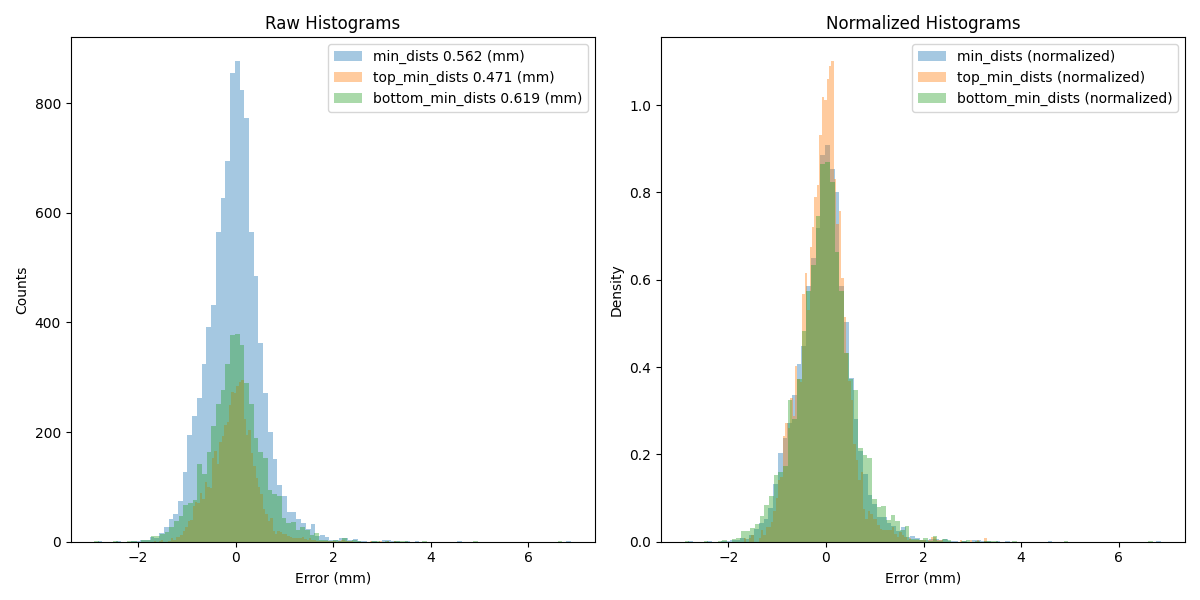

In [40]:
# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# First subplot: Raw histograms
plt.subplot(1, 2, 1)  # (rows, columns, position)
plt.hist(min_dists_mm, bins=100, alpha=0.4, label=f'min_dists {np.std(min_dists)*1e2:.3f} (mm)')
plt.hist(top_min_dists_mm,  bins=100, alpha=0.4, label=f'top_min_dists {np.std(top_min_dists)*1e2:.3f} (mm)')
plt.hist(bottom_min_dists_mm, bins=100, alpha=0.4, label=f'bottom_min_dists {np.std(bottom_min_dists)*1e2:.3f} (mm)')
plt.legend()
plt.title('Raw Histograms')
plt.xlabel('Error (mm)')
plt.ylabel('Counts')

# Second subplot: Normalized histograms
plt.subplot(1, 2, 2)  # (rows, columns, position)
plt.hist(min_dists_mm, bins=100, alpha=0.4, density=True, label='min_dists (normalized)')
plt.hist(top_min_dists_mm, bins=100, alpha=0.4, density=True, label='top_min_dists (normalized)')
plt.hist(bottom_min_dists_mm, bins=100, alpha=0.4, density=True, label='bottom_min_dists (normalized)')
plt.legend()
plt.title('Normalized Histograms')
plt.xlabel('Error (mm)')
plt.ylabel('Density')

# Show the plots
plt.tight_layout()
plt.show()

In [41]:
min_dists = hexa.compute_min_distances(transformed_points, normals, vertices)
top_min_dists = hexa.compute_min_distances(top_transformed_points, normals, vertices)
bottom_min_dists = hexa.compute_min_distances(bottom_transformed_points, normals, vertices)


# Error analysis
This part of the code is still under development. Need to fix functions

In [55]:


def perturb_axis_and_evaluate(transformed_points, radius, center, perturbation_angles):
    """
    Perturbs the hexagonal rod's axis, computes hexagon parameters, and evaluates fit.

    Parameters:
    - transformed_points: data points to be evaluated.
    - radius: radius of the hexagon.
    - center: center of the hexagon.
    - perturbation_angles: list or array of perturbation angles (in degrees).

    Returns:
    - perturbation_angles: list of perturbation angles used.
    - medians: list of median distances for each perturbation.
    - std_devs: list of standard deviations of distances for each perturbation.
    """
    # Initial axis of the rod
    base_axis = np.array([0, 0, 1])  
    
    medians = []
    std_devs = []
    
    for angle in perturbation_angles:
        # Generate a small perturbation rotation about a random axis
        random_axis = np.random.randn(3)  # Random 3D vector
        random_axis /= np.linalg.norm(random_axis)  # Normalize to make it a unit vector
        
        # Create rotation around the random axis by the given angle
        rotation = R.from_rotvec(np.radians(angle) * random_axis)
        perturbed_axis = rotation.apply(base_axis)

        # Generate hexagonal parameters with the perturbed axis
        vertices, corners, normals = hexa.hexagon_generation_parameters(radius, angle, center, perturbed_axis)
        
        # Compute distances to the model
        min_dists = hexa.compute_min_distances(transformed_points, normals, vertices)
        
        # Compute median and standard deviation
        medians.append(np.median(min_dists))
        std_devs.append(np.std(min_dists))
    
    return perturbation_angles, medians, std_devs


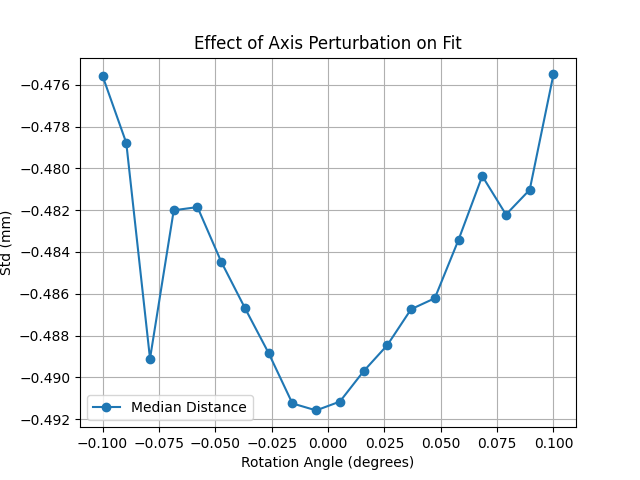

In [56]:
perturbation_angles = np.linspace(-0.1, 0.1, 20)  # Perturb from -5 to 5 degrees

angles, medians, std_devs = perturb_axis_and_evaluate(transformed_points, radius=10, 
                                                      center=[0, 0, 0], 
                                                      perturbation_angles=perturbation_angles)

plt.figure()
plt.plot(angles, medians, label="Median Distance", marker="o")
# plt.plot(angles, np.array(std_devs)*100, label="Standard Deviation", marker="s")
plt.xlabel("Rotation Angle (degrees)")
plt.ylabel("Std (mm)")
plt.title("Effect of Axis Perturbation on Fit")
plt.legend()
plt.grid(True)
plt.show()


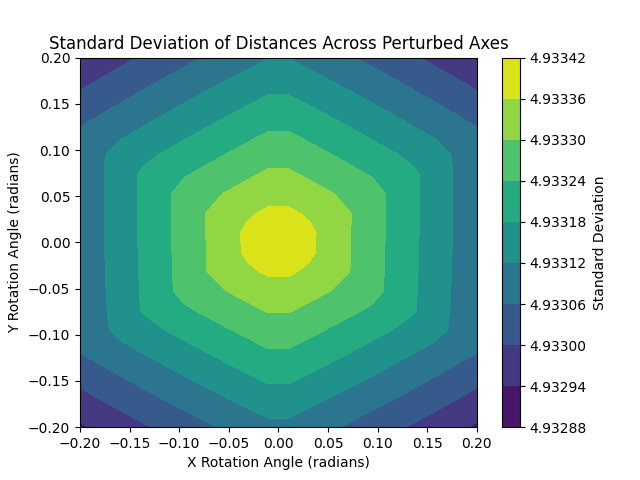

In [64]:
# Define the range of rotation angles
angle_range = np.linspace(-0.2, 0.2, 20)   
x_angles, y_angles = np.meshgrid(angle_range, angle_range)  # Create grid

# Initialize maps to store metrics
std_map = np.zeros_like(x_angles)  # Storage for standard deviations
median_dist_map = np.zeros_like(x_angles)  # Storage for median distances
min_dist_map = np.zeros_like(x_angles)  # Storage for minimum distances
distances = np.zeros((x_angles.shape[0], x_angles.shape[1], len(transformed_points)))  # Store all distances

# Base axis (assumed Z-axis)
base_axis = np.array([0, 0, 1])

# Loop over the grid of angles
for i in range(x_angles.shape[0]):
    for j in range(x_angles.shape[1]):
        x_angle = x_angles[i, j]
        y_angle = y_angles[i, j]
        
        # Apply two rotations: first around x-axis, then around y-axis
        rotation = R.from_euler('xy', [x_angle, y_angle], degrees=True)
        perturbed_axis = rotation.apply(base_axis)  # Apply rotation to the base axis

        # Generate hexagonal parameters with the perturbed axis
        vertices, corners, normals = hexa.hexagon_generation_parameters(radius, angle, center, perturbed_axis)
        
        # Compute minimum distances between transformed points and the hexagonal geometry
        min_dists = hexa.compute_min_distances(transformed_points, normals, vertices)

        # Store metrics
        std_map[i, j] = np.std(min_dists)  # Standard deviation of distances
        median_dist_map[i, j] = np.median(min_dists)  # Median of distances
        min_dist_map[i, j] = np.min(min_dists)  # Minimum distance
        distances[i, j, :] = min_dists  # Store all distances for this perturbation

# Plotting the standard deviation map
plt.figure()
plt.contourf(x_angles, y_angles, std_map, cmap='viridis')
plt.colorbar(label="Standard Deviation")
plt.title("Standard Deviation of Distances Across Perturbed Axes")
plt.xlabel("X Rotation Angle (radians)")
plt.ylabel("Y Rotation Angle (radians)")
plt.show()


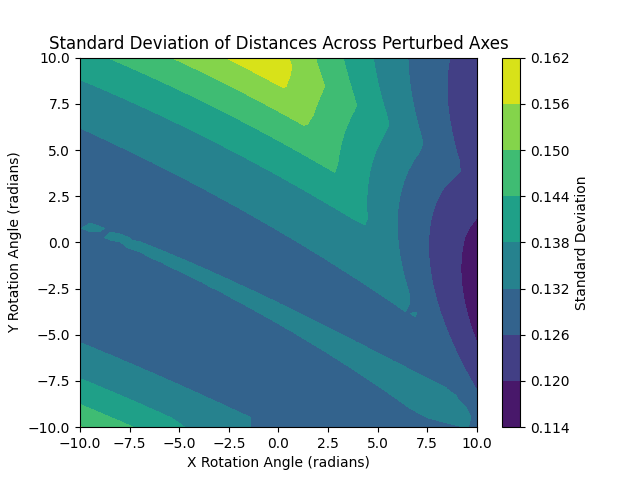

In [87]:
# Define the range of rotation angles
angle_range = np.linspace(-10, 10, 40)   
x_angles, y_angles = np.meshgrid(angle_range, angle_range)  # Create grid

# Initialize maps to store metrics
std_map = np.zeros_like(x_angles)  # Storage for standard deviations
median_dist_map = np.zeros_like(x_angles)  # Storage for median distances
min_dist_map = np.zeros_like(x_angles)  # Storage for minimum distances
distances = np.zeros((x_angles.shape[0], x_angles.shape[1], len(transformed_points)))  # Store all distances

# Base axis (assumed Z-axis)
base_axis = np.array([0, 0, 1])

# Loop over the grid of angles
for i in range(x_angles.shape[0]):
    for j in range(x_angles.shape[1]):
        x_angle = x_angles[i, j]
        y_angle = y_angles[i, j]
        # Apply two rotations: first around x-axis, then around y-axis
        rotation = R.from_euler('yx', [x_angle, y_angle], degrees=True)
        perturbed_axis = rotation.apply(base_axis)  # Apply rotation to the base axis
        # print(f"Perturbed axis for x={x_angle}, y={y_angle}: {perturbed_axis}")
        
        vertices = fun.hexagon_vertices(center, radius, angle, perturbed_axis)
        # vertices_np = np.array(vertices)
        # print(vertices)
        corners = hexa.compute_corners(vertices)
        # print(corners)
        normals = np.empty((6,3))
        # print(normals)
        for k in range(len(corners)):
            normals[k] = hexa.compute_normal_from_corners(corners[k])
        # Compute minimum distances between transformed points and the hexagonal geometry
        min_dists = hexa.compute_min_distances(transformed_points, normals, vertices)

        # Store metrics
        std_map[i, j] = np.std(min_dists)  # Standard deviation of distances
        median_dist_map[i, j] = np.median(min_dists)  # Median of distances
        min_dist_map[i, j] = np.min(min_dists)  # Minimum distance
        distances[i, j, :] = min_dists  # Store all distances for this perturbation

# Plotting the standard deviation map
plt.figure()
plt.contourf(x_angles, y_angles, std_map, cmap='viridis')
plt.colorbar(label="Standard Deviation")
plt.title("Standard Deviation of Distances Across Perturbed Axes")
plt.xlabel("X Rotation Angle (radians)")
plt.ylabel("Y Rotation Angle (radians)")
plt.show()


Standard Deviation range: 0.13108806603669 0.13164015237999477


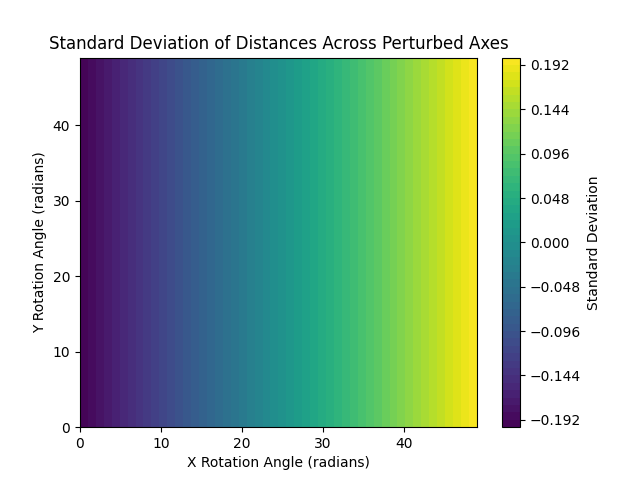

In [92]:
# Define the range of rotation angles
angle_range = np.linspace(-0.2, 0.2, 50)   # Increased resolution
x_angles, y_angles = np.meshgrid(angle_range, angle_range)  # Create grid

# Initialize maps to store metrics
std_map = np.zeros_like(x_angles)  # Storage for standard deviations
median_dist_map = np.zeros_like(x_angles)  # Storage for median distances
min_dist_map = np.zeros_like(x_angles)  # Storage for minimum distances
distances = np.zeros((x_angles.shape[0], x_angles.shape[1], len(transformed_points)))  # Store all distances

# Base axis (assumed Z-axis)
base_axis = np.array([0, 0, 1])

# Loop over the grid of angles
for i in range(x_angles.shape[0]):
    for j in range(x_angles.shape[1]):
        x_angle = x_angles[i, j]
        y_angle = y_angles[i, j]
        
        # Apply two rotations: first around x-axis, then around y-axis
        rotation = R.from_euler('yx', [x_angle, y_angle], degrees=True)
        perturbed_axis = rotation.apply(base_axis)  # Apply rotation to the base axis

        vertices = fun.hexagon_vertices(center, radius, angle, perturbed_axis)

        corners = hexa.compute_corners(vertices)

        normals = np.empty((6, 3))
        for corner_idx in range(len(corners)):  # Changed inner loop index
            normals[corner_idx] = hexa.compute_normal_from_corners(corners[corner_idx])

        # Compute minimum distances between transformed points and the hexagonal geometry
        min_dists = hexa.compute_min_distances(transformed_points, normals, vertices)

        # Store metrics
        std_map[i, j] = np.std(min_dists)  # Standard deviation of distances
        median_dist_map[i, j] = np.median(min_dists)  # Median of distances
        min_dist_map[i, j] = np.min(min_dists)  # Minimum distance
        distances[i, j, :] = min_dists  # Store all distances for this perturbation

# Check the range of standard deviations (optional)
print("Standard Deviation range:", np.min(std_map), np.max(std_map))

# Plotting the standard deviation map
plt.figure()
# plt.contourf(x_angles, y_angles, std_map, cmap='viridis')
contour = plt.contourf(x_angles, y_angles,# std_map*1e5,
                       levels=50, cmap='viridis', 
                       # norm=norm
                      )
plt.colorbar(label="Standard Deviation")
plt.title("Standard Deviation of Distances Across Perturbed Axes")
plt.xlabel("X Rotation Angle (radians)")
plt.ylabel("Y Rotation Angle (radians)")
plt.show()


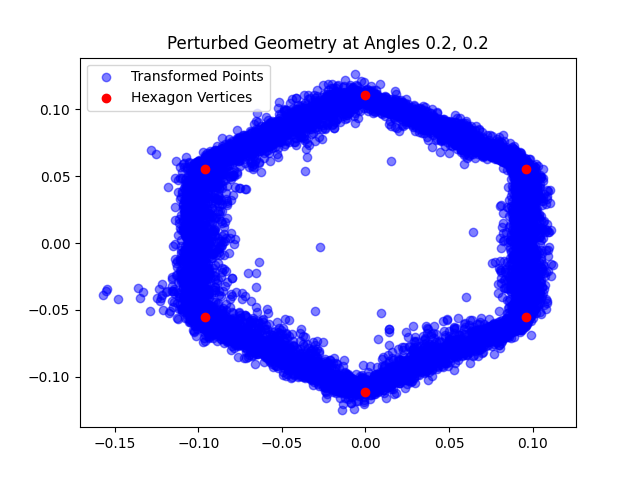

In [69]:
# Plot perturbed hexagon geometry
plt.figure()

plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c='b', label="Transformed Points", alpha=0.5)
plt.scatter(vertices[:, 0], vertices[:, 1], c='r', label="Hexagon Vertices", alpha=1)
plt.legend()
plt.title(f"Perturbed Geometry at Angles {x_angle}, {y_angle}")
plt.show()


In [58]:

angle_range = np.linspace(-0.2, 0.2, 40)  # Rotate from -5 to 5 degrees
x_angles, y_angles = np.meshgrid(angle_range, angle_range)  # Create grid

std_map = np.zeros_like(x_angles)  # Storage for standard deviations
median_dist_map = np.zeros_like(x_angles)  # Storage for minimum distances
min_dist_map = np.zeros_like(x_angles)  # Storage for minimum distances
distances = np.zeros((x_angles.shape[0], x_angles.shape[1], len(transformed_points)))  # Store all distances

# Base axis
base_axis = np.array([0, 0, 1])

for i in range(x_angles.shape[0]):
    for j in range(x_angles.shape[1]):
        x_angle = x_angles[i, j]
        y_angle = y_angles[i, j]
        
        # Apply two rotations: first around x, then around y
        rotation = R.from_euler('xy', [x_angle, y_angle], degrees=True)
        perturbed_axis = rotation.apply(base_axis)

        # Generate hexagonal parameters with perturbed axis
        vertices, corners, normals = hexagon_generation(radius, angle, center, perturbed_axis)
        
        # Compute distances
        min_dists = hexa.compute_min_distances(transformed_points, normals, vertices)
        std_map[i, j] = np.std(min_dists)  # Store standard deviation
        median_dist_map[i, j] = np.median(min_dists)  # Store median distance
        min_dist_map[i, j] = np.min(min_dists)  # Store min distance
        distances[i, j, :] = min_dists  # Store all distances at this perturbation


TypeError: hexagon_vertices() takes from 2 to 3 positional arguments but 4 were given

In [47]:
angle_range = np.linspace(-0.2, 0.2, 40)  # Rotate from -5 to 5 degrees
x_angles, y_angles = np.meshgrid(angle_range, angle_range)  # Create grid

std_map = np.zeros_like(x_angles)  # Storage for standard deviations
median_dist_map = np.zeros_like(x_angles)  # Storage for minimum distances
min_dist_map = np.zeros_like(x_angles)  # Storage for minimum distances
distances = np.zeros((x_angles.shape[0], x_angles.shape[1], len(bottom_transformed_points)))  # Store all distances

# Base axis
base_axis = np.array([0, 0, 1])

for i in range(x_angles.shape[0]):
    for j in range(x_angles.shape[1]):
        x_angle = x_angles[i, j]
        y_angle = y_angles[i, j]
        
        # Apply two rotations: first around x, then around y
        rotation = R.from_euler('xy', [x_angle, y_angle], degrees=True)
        perturbed_axis = rotation.apply(base_axis)

        # Generate hexagonal parameters with perturbed axis
        vertices, corners, normals = hexa.generate_hexagon_parameters(radius, angle, center, perturbed_axis)
        
        # Compute distances
        min_dists = hexa.compute_min_distances(bottom_transformed_points, normals, vertices)
        std_map[i, j] = np.std(min_dists)  # Store standard deviation
        median_dist_map[i, j] = np.median(min_dists)  # Store median distance
        min_dist_map[i, j] = np.min(min_dists)  # Store min distance
        distances[i, j, :] = min_dists  # Store all distances at this perturbation


In [540]:
# Compute chi-squared map by summing over all 10,000 distances per grid point
# chi2_map = np.sum((distances / std_map[:, :, np.newaxis]) ** 2, axis=2)
chi2_map = np.sum((distances ** 2) / (std_map[:, :, np.newaxis] ** 2), axis=2)

# Find minimum chi-squared value
chi2_min = np.min(chi2_map)

# Compute delta chi-squared
delta_chi2_map = chi2_map - chi2_min


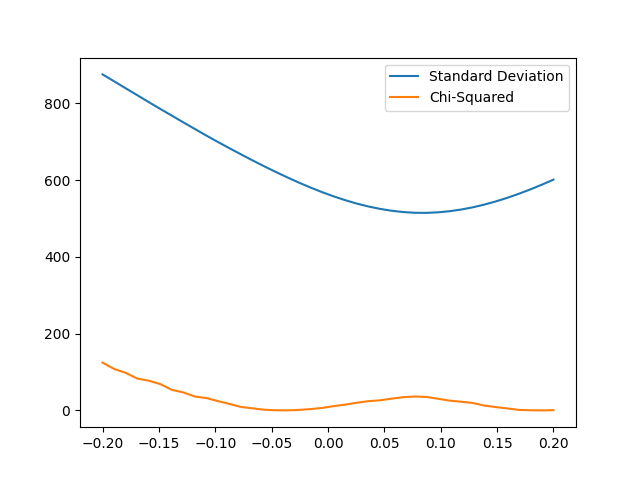

In [541]:
plt.figure()
plt.plot(angle_range, 1e5*std_map[:, std_map.shape[1]//2], label="Standard Deviation")
plt.plot(angle_range, delta_chi2_map[:, delta_chi2_map.shape[1]//2], label="Chi-Squared")
plt.legend()
plt.show()


In [486]:
print(distances.shape)  # This will print the shape of the distances array
print(std_map.shape)    

(40, 40, 9947)
(40, 40)


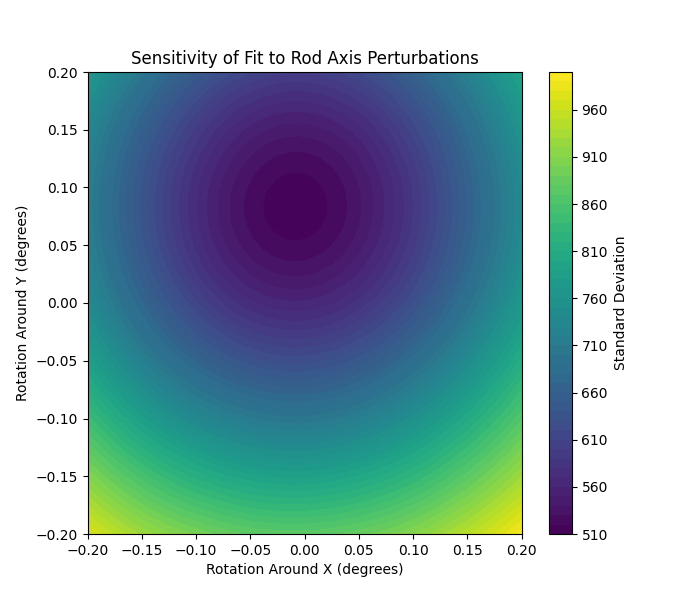

In [546]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# norm = colors.Normalize(vmin=510, vmax=600)

# Plot the heatmap with the custom normalization (this clips the colors but not the data)
plt.figure(figsize=(7, 6))
contour = plt.contourf(x_angles, y_angles, std_map*1e5, levels=50, cmap='viridis', 
                       # norm=norm
                      )

# Add colorbar with label
cbar = plt.colorbar(contour)
cbar.set_label("Standard Deviation")
# cbar.set_ticks([510, 600])  # Set specific ticks for the colorbar
# cbar.set_ticklabels([510, 600])  # Ensure the tick labels are displayed correctly
# plt.xlim(-0.1, 0.1)
# plt.ylim(0.0, 0.2)
plt.xlabel("Rotation Around X (degrees)")
plt.ylabel("Rotation Around Y (degrees)")
plt.title("Sensitivity of Fit to Rod Axis Perturbations")
plt.show()


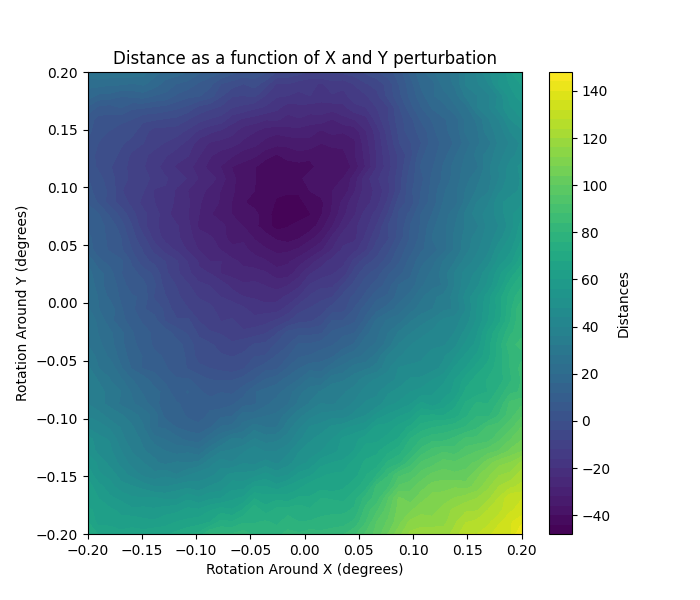

In [543]:
#norm = colors.Normalize(vmin=510, vmax=600)

# Plot the heatmap with the custom normalization (this clips the colors but not the data)
plt.figure(figsize=(7, 6))
contour = plt.contourf(x_angles, y_angles, median_dist_map*1e5, levels=50, cmap='viridis', 
                     #  norm=norm
                      )

# Add colorbar with label
cbar = plt.colorbar(contour)
cbar.set_label("Distances")
# cbar.set_ticks([510, 600])  # Set specific ticks for the colorbar
# cbar.set_ticklabels([510, 600])  # Ensure the tick labels are displayed correctly
# plt.xlim(-0.1, 0.1)
# plt.ylim(0.0, 0.2)
plt.xlabel("Rotation Around X (degrees)")
plt.ylabel("Rotation Around Y (degrees)")
plt.title("Distance as a function of X and Y perturbation")
plt.show()


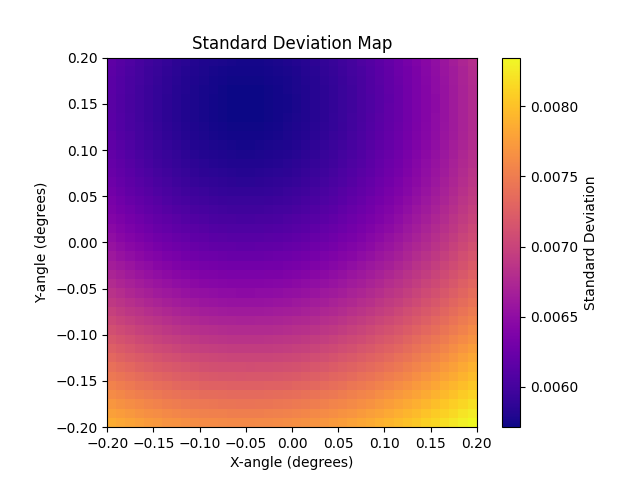

In [513]:
plt.figure()
plt.imshow(std_map, extent=[angle_range.min(), angle_range.max(), angle_range.min(), angle_range.max()], origin='lower', cmap='plasma')
plt.colorbar(label='Standard Deviation')
plt.title("Standard Deviation Map")
plt.xlabel("X-angle (degrees)")
plt.ylabel("Y-angle (degrees)")
plt.show()


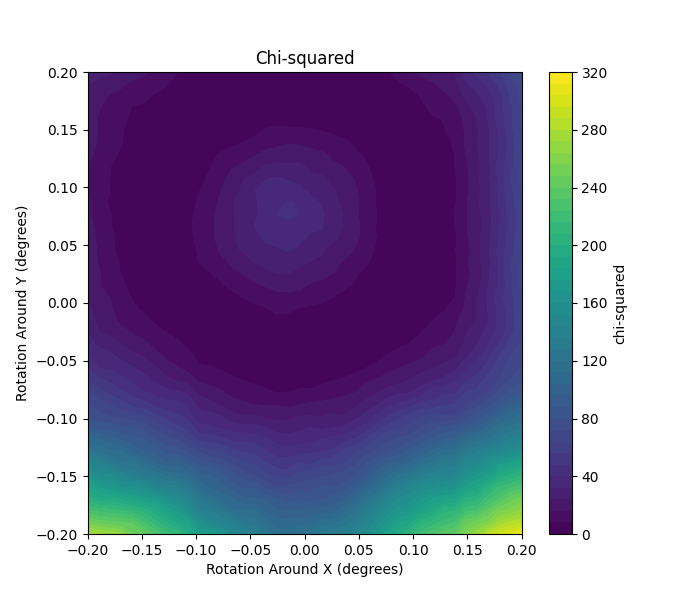

In [544]:
#norm = colors.Normalize(vmin=510, vmax=600)

# Plot the heatmap with the custom normalization (this clips the colors but not the data)
plt.figure(figsize=(7, 6))
contour = plt.contourf(x_angles, y_angles, delta_chi2_map, levels=50, cmap='viridis', 
                     #  norm=norm
                      )

# Add colorbar with label
cbar = plt.colorbar(contour)
cbar.set_label("chi-squared")
# cbar.set_ticks([510, 600])  # Set specific ticks for the colorbar
# cbar.set_ticklabels([510, 600])  # Ensure the tick labels are displayed correctly
# plt.xlim(-0.1, 0.1)
# plt.ylim(0.0, 0.2)
plt.xlabel("Rotation Around X (degrees)")
plt.ylabel("Rotation Around Y (degrees)")
plt.title("Chi-squared")
plt.show()


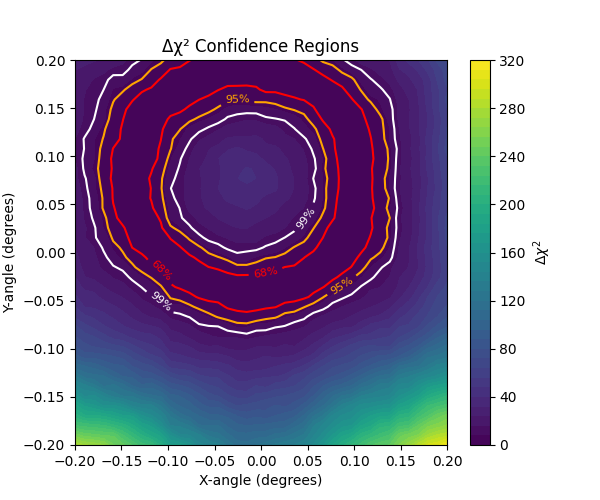

In [545]:
import matplotlib.pyplot as plt

# Define confidence levels
confidence_levels = [2.30, 6.18, 11.83]  # 68%, 95%, 99% confidence

plt.figure(figsize=(6, 5))

# Contour plot of delta chi-squared
contour_filled = plt.contourf(x_angles, y_angles, delta_chi2_map, levels=50, cmap='viridis')
plt.colorbar(label=r'$\Delta\chi^2$')  # Colorbar

# Confidence level contours
# contour_lines = plt.contour(x_angles, y_angles, delta_chi2_map, levels=confidence_levels, colors=['red', 'orange', 'white'])

contour_lines = plt.contour(x_angles, y_angles, delta_chi2_map, 
                            levels=confidence_levels, 
                            colors=['red', 'orange', 'white'], 
                            linewidths=1.5)


# Add labels to contours
plt.clabel(contour_lines, inline=True, fontsize=8, fmt={2.30: '68%', 6.18: '95%', 11.83: '99%'})

# Labels and title
plt.xlabel("X-angle (degrees)")
plt.ylabel("Y-angle (degrees)")
plt.title("Δχ² Confidence Regions")

# Show the plot
plt.show()


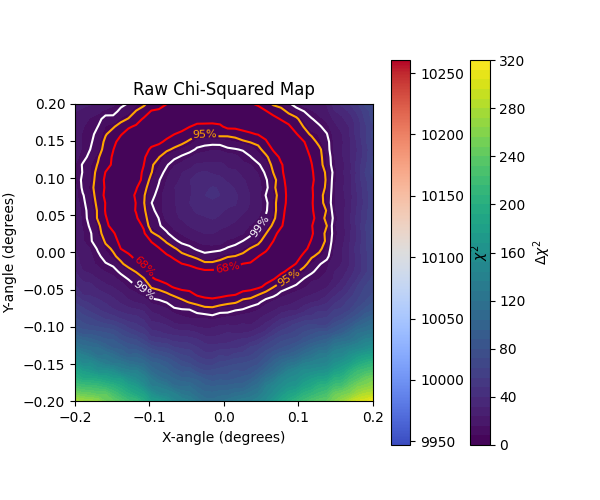

In [464]:
plt.imshow(chi2_map, extent=[x_angles.min(), x_angles.max(), y_angles.min(), y_angles.max()], origin='lower', cmap='coolwarm')
plt.colorbar(label=r'$\chi^2$')
plt.title("Raw Chi-Squared Map")
plt.xlabel("X-angle (degrees)")
plt.ylabel("Y-angle (degrees)")
plt.show()



In [429]:
# Perturbation ranges
axis_perturb_x = np.radians(np.linspace(-0.5, 0.5, 10))  # +/- 0.5 degrees in x
axis_perturb_y = np.radians(np.linspace(-0.5, 0.5, 10))  # +/- 0.5 degrees in y
center_perturb_z = np.linspace(-0.001, 0.001, 5)  # Small perturbation in z
radius_perturb = np.linspace(0.9 * radius, 1.1 * radius, 10)  # +/-10%
angle_perturb = np.radians(np.linspace(27, 33, 10))  # +/-10% in degrees

vertices, corners, normals = fun.hexagon_generation(radius, angle, center, axis)
distances = hexa.compute_min_distances(transformed_points, normals, vertices)

# Grid search over parameter perturbations
ssr_results = []
for dx in axis_perturb_x:
    for dy in axis_perturb_y:
        perturbed_axis = np.array([dx, dy, np.sqrt(1 - dx**2 - dy**2)])
        for dz in center_perturb_z:
            perturbed_center = cylinder_center_pcd + np.array([0, 0, dz])
            for r in radius_perturb:
                for a in angle_perturb:
                    ssr = hexa.compute_min_distances(transformed_points, perturbed_axis, perturbed_center, r, a)
                    ssr_results.append([dx, dy, dz, r, a, ssr])

# Convert to array for visualization
ssr_results = np.array(ssr_results)

# Visualization (example: SSR vs radius perturbation)
plt.scatter(ssr_results[:, 3], ssr_results[:, 5])
plt.xlabel("Radius Perturbation")
plt.ylabel("Sum of Squared Residuals")
plt.title("Effect of Radius Perturbation on Model Fit")
plt.show()

0.005132764795094282

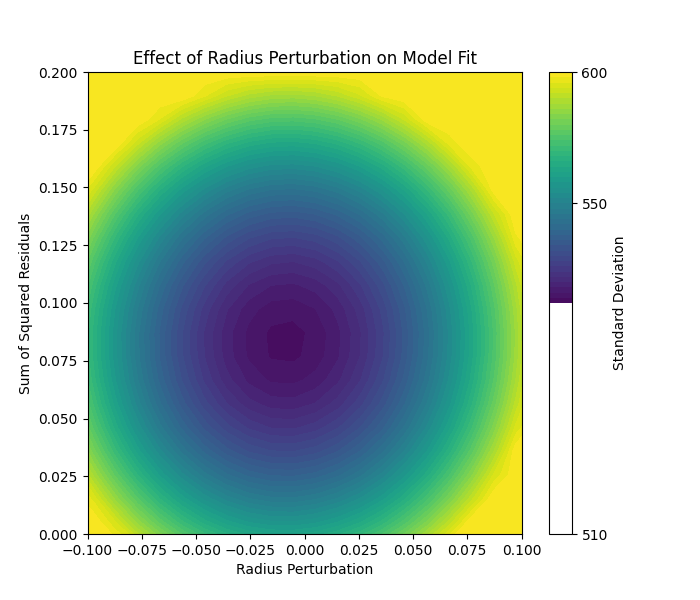

In [439]:
from scipy.spatial import distance

# Hexagonal rod parameters
cylinder_axis_pcd = np.array([0, 0, 1])  # Initial guess for axis
cylinder_center_pcd = np.array([0, 0, 0])  # Center of rod
radius = 0.111  # Edge-to-edge distance
angle = np.radians(30)  # Rotation in radians

# Perturbation ranges
axis_perturb_x = np.radians(np.linspace(-0.5, 0.5, 10))  # +/- 0.5 degrees in x
axis_perturb_y = np.radians(np.linspace(-0.5, 0.5, 10))  # +/- 0.5 degrees in y
center_perturb_z = np.linspace(-0.001, 0.001, 5)  # Small perturbation in z
radius_perturb = np.linspace(0.9 * radius, 1.1 * radius, 10)  # +/-10%
angle_perturb = np.radians(np.linspace(27, 33, 10))  # +/-10% in degrees

# Function to compute residual statistics
def compute_residual_statistics(distances):
    mean_residual = np.mean(distances)
    std_residual = np.std(distances)
    sum_squared_residuals = np.sum(distances**2)
    return mean_residual, std_residual, sum_squared_residuals

# Grid search over parameter perturbations
ssr_results = []
for dx in axis_perturb_x:
    for dy in axis_perturb_y:
        perturbed_axis = np.array([dx, dy, np.sqrt(1 - dx**2 - dy**2)])
        for dz in center_perturb_z:
            perturbed_center = cylinder_center_pcd + np.array([0, 0, dz])
            for r in radius_perturb:
                for a in angle_perturb:
                    vertices, corners, normals = hexa.hexagon_generation(r, a, perturbed_center, perturbed_axis)
                    distances = hexa.compute_min_distances(transformed_points, normals, vertices)
                    distances = np.array(distances)
                    mean_residual, std_residual, ssr = compute_residual_statistics(distances)
                    ssr_results.append([dx, dy, dz, r, a, mean_residual, std_residual, ssr])

# Convert to array for visualization
ssr_results = np.array(ssr_results)

# Visualization (example: SSR vs radius perturbation)
plt.scatter(ssr_results[:, 3], ssr_results[:, 7])
plt.xlabel("Radius Perturbation")
plt.ylabel("Sum of Squared Residuals")
plt.title("Effect of Radius Perturbation on Model Fit")
plt.show()

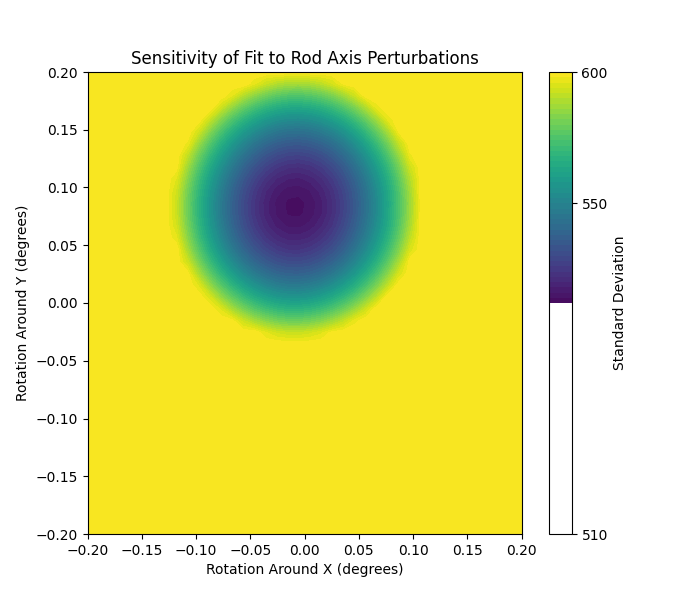

In [414]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# Clip the data values to the range 500 to 600, but don't modify the data itself in the plot
clipped_data = np.clip(std_map * 1e5, 510, 600)

# Create a custom Normalize object for the colorbar
norm = colors.Normalize(vmin=510, vmax=600)

# Plot the heatmap with the clipped data and the custom normalization for the colorbar
plt.figure(figsize=(7, 6))
contour = plt.contourf(x_angles, y_angles, clipped_data, levels=50, cmap='viridis', norm=norm)

# Add colorbar with label
cbar = plt.colorbar(contour)
cbar.set_label("Standard Deviation")
cbar.set_ticks([510, 550, 600])  # Set specific ticks for the colorbar
cbar.set_ticklabels([510, 550, 600])  # Ensure the tick labels are displayed correctly

plt.xlabel("Rotation Around X (degrees)")
plt.ylabel("Rotation Around Y (degrees)")
plt.title("Sensitivity of Fit to Rod Axis Perturbations")
plt.show()


In [ ]:
import numpy as np
import emcee

# Define the log-likelihood (negative of your objective function)
def log_likelihood(params, data_points, transformed_points):
    # Extract parameters
    center_x, center_y, center_z, angle_x, angle_y, angle_z, diameter, axis_x, axis_y, axis_z = params
    
    # Apply perturbations to the parameters and compute the model's fit
    # Generate hexagonal parameters and compute distances as in the earlier approach
    vertices, corners, normals = hexagon_generation(radius=diameter, angle=angle_x, 
                                                    center=[center_x, center_y, center_z], axis=[axis_x, axis_y, axis_z])
    min_dists = compute_min_distances(transformed_points, normals, vertices)
    
    # Return negative of standard deviation (log-likelihood = -log(p))
    return -np.std(min_dists)

# Define the prior function (for example, using uniform priors)
def log_prior(params):
    # Assuming uniform priors for all parameters within reasonable bounds
    if not (0 < params[6] < 20):  # diameter in range
        return -np.inf
    if not (-1 < params[7] < 1 and -1 < params[8] < 1 and -1 < params[9] < 1):  # axis direction
        return -np.inf
    # More priors for other parameters (center, angles)
    return 0

# Define the log-probability function
def log_probability(params, data_points, transformed_points):
    lp = log_prior(params)
    if np.isinf(lp):
        return -np.inf
    return lp + log_likelihood(params, data_points, transformed_points)

# Set up MCMC using emcee
nwalkers = 50
ndim = 10  # 10 parameters
nsteps = 1000

# Initial guess for the walkers (randomly sample within bounds)
initial_pos = np.random.rand(nwalkers, ndim) * 2 - 1  # Random position within the bounds

# Initialize the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(data_points, transformed_points))

# Run MCMC
sampler.run_mcmc(initial_pos, nsteps)

# Analyze the results
samples = sampler.get_chain()
print("Samples:", samples)

# Get the best-fit parameters (mean of the posterior)
best_params = np.mean(samples, axis=0)
print("Best parameters:", best_params)

# You can also check convergence diagnostics here


In [ ]:
def plot_mcmc_chains(samples, parameter_names):
    """
    Plots the MCMC chains for each parameter to visualize convergence.
    
    Args:
    - samples: The MCMC chain (non-flattened).
    - parameter_names: List of parameter names for the chains.
    """
    # Plot each chain for each parameter
    nparams = samples.shape[2]  # Number of parameters
    fig, axes = plt.subplots(nparams, figsize=(10, 3 * nparams))

    for i in range(nparams):
        ax = axes[i]
        for walker in range(samples.shape[0]):  # Loop over all walkers
            ax.plot(samples[walker, :, i], color='gray', alpha=0.5)
        ax.set_xlabel('Step')
        ax.set_ylabel(parameter_names[i])
        ax.set_title(f'MCMC Chain for {parameter_names[i]}')

    plt.tight_layout()
    plt.show()

# Example usage:
# Plot the MCMC chains
plot_mcmc_chains(sampler.get_chain(), parameter_names)


In [ ]:
def plot_mcmc_chains(samples, parameter_names):
    """
    Plots the MCMC chains for each parameter to visualize convergence.
    
    Args:
    - samples: The MCMC chain (non-flattened).
    - parameter_names: List of parameter names for the chains.
    """
    # Plot each chain for each parameter
    nparams = samples.shape[2]  # Number of parameters
    fig, axes = plt.subplots(nparams, figsize=(10, 3 * nparams))

    for i in range(nparams):
        ax = axes[i]
        for walker in range(samples.shape[0]):  # Loop over all walkers
            ax.plot(samples[walker, :, i], color='gray', alpha=0.5)
        ax.set_xlabel('Step')
        ax.set_ylabel(parameter_names[i])
        ax.set_title(f'MCMC Chain for {parameter_names[i]}')

    plt.tight_layout()
    plt.show()

# Example usage:
# Plot the MCMC chains
plot_mcmc_chains(sampler.get_chain(), parameter_names)


In [399]:

angle_range = np.linspace(-0.2, 0.2, 10)  # Rotate from -5 to 5 degrees
x_angles, y_angles = np.meshgrid(angle_range, angle_range)  # Create grid

std_map = np.zeros_like(x_angles)  # Storage for standard deviations

# Base axis
base_axis = np.array([0, 0, 1])

for i in range(x_angles.shape[0]):
    for j in range(x_angles.shape[1]):
        x_angle = x_angles[i, j]
        y_angle = y_angles[i, j]
        
        # Apply two rotations: first around x, then around y
        rotation = R.from_euler('xy', [x_angle, y_angle], degrees=True)
        perturbed_axis = rotation.apply(base_axis)

        # Generate hexagonal parameters with perturbed axis
        vertices, corners, normals = hexa.hexagon_generation(radius, angle, center, perturbed_axis)
        
        # Compute distances
        min_dists = hexa.compute_min_distances(transformed_points, normals, vertices)
        std_map[i, j] = np.std(min_dists)  # Store standard deviation


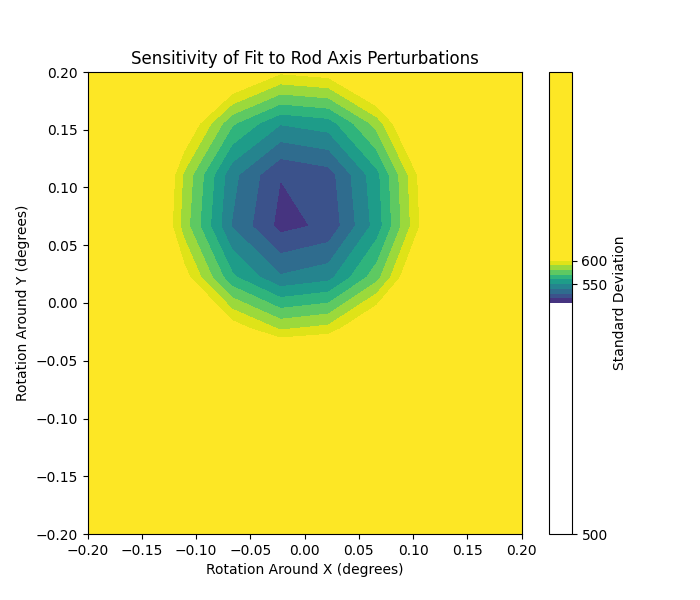

In [404]:

# Plot the heatmap
plt.figure(figsize=(7, 6))
contour = plt.contourf(x_angles, y_angles, std_map*1e5, levels=50, cmap='viridis',
                       vmin=500, vmax=600)  # Corrected vmin instead of vmix
# Add colorbar with label
cbar = plt.colorbar(contour)
cbar.set_label("Standard Deviation")
cbar.set_ticks([500, 550, 600])  # Optional: Set specific ticks for the colorbar

plt.xlabel("Rotation Around X (degrees)")
plt.ylabel("Rotation Around Y (degrees)")
plt.title("Sensitivity of Fit to Rod Axis Perturbations")
plt.show()


In [394]:
# Find the index of the minimum standard deviation
min_index = np.unravel_index(np.argmin(std_map), std_map.shape)
preferred_x_angle = x_angles[min_index]
preferred_y_angle = y_angles[min_index]
min_std = std_map[min_index]

print(f"Preferred Rotation: X = {preferred_x_angle:.2f}°, Y = {preferred_y_angle:.2f}°")
print(f"Minimum Standard Deviation: {min_std:.4f}")


Preferred Rotation: X = -0.01°, Y = 0.09°
Minimum Standard Deviation: 0.0051


In [395]:
valid_indices = ~np.isnan(z_data) & ~np.isinf(z_data)
x_data = x_data[valid_indices]
y_data = y_data[valid_indices]
z_data = z_data[valid_indices]


In [396]:
from scipy.optimize import curve_fit

# Define 2D Gaussian function for fitting
def gaussian_2d(xy, x0, y0, sigma_x, sigma_y, A, offset):
    x, y = xy
    return offset + A * np.exp(-(((x - x0) ** 2) / (2 * sigma_x ** 2) + ((y - y0) ** 2) / (2 * sigma_y ** 2)))

# Flatten data for curve fitting
x_data = x_angles.ravel()
y_data = y_angles.ravel()
z_data = std_map.ravel()

# Initial guesses: center at min std, some broad initial sigma
p0 = [preferred_x_angle, preferred_y_angle, 0.002, 0.002, -1, np.max(z_data)] 

# Fit the 2D Gaussian to the data
popt, _ = curve_fit(gaussian_2d, (x_data, y_data), z_data, p0=p0, maxfev=5000)

# Extract fitted parameters
fit_x0, fit_y0, sigma_x, sigma_y, _, _ = popt
print(f"Uncertainty in X rotation: {sigma_x:.2f}°")
print(f"Uncertainty in Y rotation: {sigma_y:.2f}°")


Uncertainty in X rotation: 0.23°
Uncertainty in Y rotation: 0.23°
